# Working with trajectory data in MATLAB

This notebook shows some examples to loading and working with anTraX results in MATLAB. The notebook can be dowloaded from [](). 

### Load data from a tracked experiment

We will use data from dataset J16. Replace the path to correct path on your system. By default, data from all IDs ('ants') and all movies will be loaded, but it can be changed using the arguments.

In [1]:
expdir = '/Users/asaf/Box Sync/anTraX/datasets/J16';
ex = trhandles(expdir);
ad = antdata(ex, 'movlist', 1, 'antlist', {'GO','PP'});

16:40:16 -I- Loading tracking session from expdir
16:40:17 -I- Reading video information from file


In [2]:
head(ad.data)


ans =

  8x3 table

    f                GO                             PP             
            x           y        or        x           y        or 
    _    ___________________________    ___________________________

    1    0.038876    0.063685    NaN    0.038876    0.063685    NaN
    2    0.038865    0.063683    NaN    0.038865    0.063683    NaN
    3    0.038875    0.063679    NaN    0.038875    0.063679    NaN
    4    0.038876    0.063675    NaN    0.038876    0.063675    NaN
    5    0.038863    0.063664    NaN    0.038863    0.063664    NaN
    6    0.038861    0.063666    NaN    0.038861    0.063666    NaN
    7    0.038861    0.063663    NaN    0.038861    0.063663    NaN
    8    0.038846    0.063657    NaN    0.038846    0.063657    NaN



### Plot the trajectories of two ants, with the background image as background

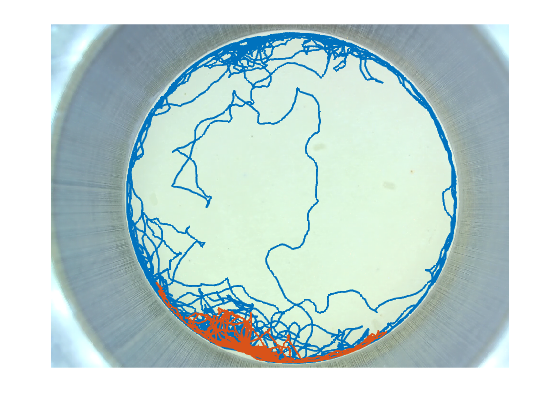

In [3]:
bg = ex.get_bg(1);
scale = ex.get_param('geometry_rscale');
imshow(bg);
hold on
ants = {'PP', 'GO'};
for i= 1:length(ants)
    ant = ants{i};
    x = ad.data.(ant).x/scale;
    y = ad.data.(ant).y/scale;
    plot(x, y, 'linewidth', 2)
end

### Plot the trajectories of all ants  

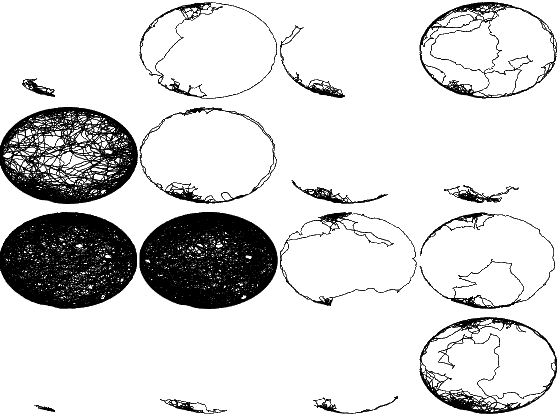

In [4]:
% load all ants this time
ad = antdata(ex, 'movlist', 1);

fig = figure;

for k=1:length(ad.antlist)
    i = ceil(k/4);
    j = k - (i-1)*4;
    pos = [(j-1)*0.25 (4-i)*0.25 0.25 0.25];
    subplot('Position',pos)
        
    ant = ad.antlist{k};
    x = ad.data.(ant).x;
    y = ad.data.(ant).y;
    plot(x, -y, 'k', 'linewidth', 0.5);
    
    xlim([0.015, 0.08]);
    ylim([-0.07, 0]);
    
    axis off
    box off
    
    
end

### Calculating some measures

Define the nest location as the median location of all ants. This is possible as in this experiment the majority of the ants are most of the time in the nest. To account for periods where many ants leave the nest for short while, we use a median temporal filter.

In [5]:
for i=1:length(ad.antlist)

    ant = ad.antlist{i};
    X(:, i) = ad.data.(ant).x;
    Y(:, i) = ad.data.(ant).y;

end


window = 3001; % 5 minues in frames 

nest = table;
nest.x = movmedian(median(X, 2, 'omitnan'), window, 'omitnan');
nest.y = movmedian(median(Y, 2, 'omitnan'), window, 'omitnan');

ad.data.nest = nest;

thresh = 0.01; % in meters
for i=1:length(ad.antlist)

    ant = ad.antlist{i};

    dx = ad.data.(ant).x - ad.data.nest.x;
    dy = ad.data.(ant).y - ad.data.nest.y;
    ad.data.(ant).dnest = sqrt(dx.^2 + dy.^2);
    ad.data.(ant).outside = ad.data.(ant).dnest > thresh;    

end

Plot the nest trajectory ontop of one frame from the experiment

16:40:24 -I- opening video file /Users/asaf/Box Sync/anTraX/datasets/J16/videos//1_3/J16_1.mp4


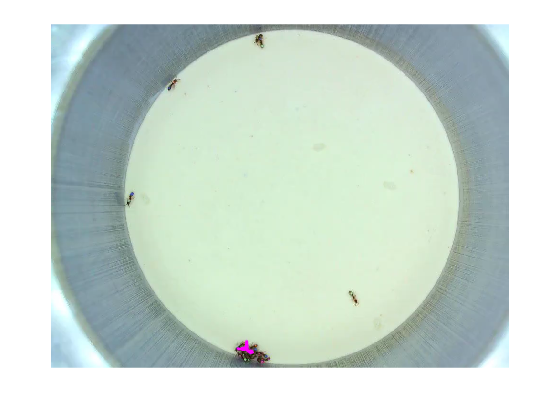

In [6]:
% load the first frame in the movie
frame = ex.read_frame(1);

% get the scale parameter to convert real world units to pixels
scale = ex.get_param('geometry_rscale');

% show the image
imshow(frame);
hold on;

% plot nest trajectory on image
x = ad.data.nest.x/scale;
y = ad.data.nest.y/scale;
plot(x, y, 'm', 'linewidth', 2)

% hide axis
box off;
axis off;

Add velocity column to data table

In [7]:
for i=1:length(ad.antlist)
    ant = ad.antlist{i};
    dx = [nan; diff(ad.data.(ant).x)];
    dy = [nan; diff(ad.data.(ant).y)];
    ad.data.(ant).v = sqrt(dx.^2 + dy.^2);
end

Plot velocity histogram when outside of the nest

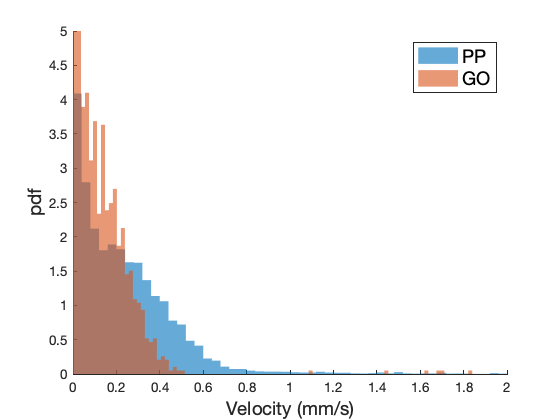

In [8]:
fig = figure;
hold on

ants = {'PP', 'GO'};

for i=1:length(ants)
    ant = ants{i};
    v = ad.data.(ant).v;
    v = v(ad.data.(ant).outside);
    v = v(~isnan(v));
    histogram(1000*v, 100, 'EdgeColor','none', 'Normalization', 'pdf')
end

xlim([0, 2]);
ylim([0, 5]);
xlabel('Velocity (mm/s)', 'FontSize', 14);
ylabel('pdf', 'FontSize', 14);
legend(ants, 'FontSize', 14);